Chapter: Understanding and Applying fSCA Analysis

1. Introduction
This chapter provides an in-depth look at the Fractional Snow-Covered Area (fSCA) analysis, highlighting its importance in remote sensing and machine learning applications for snow cover assessment. fSCA analysis plays a critical role in water resource management, climate modeling, and understanding the hydrological cycles affected by snow cover dynamics.


2. Remote Sensing of Snow Cover
Remote sensing technologies have revolutionized the monitoring of snow cover across vast and inaccessible areas. By employing satellites equipped with advanced sensors, scientists can capture detailed imagery in visible and infrared spectra, allowing for the effective differentiation of snow-covered landscapes from other land covers. The Normalized Difference Snow Index (NDSI) and similar indices leverage the unique reflective properties of snow to map snow cover with high accuracy.

2.1. Satellite Imagery in Snow Analysis
The use of satellite imagery for snow analysis involves various satellites, such as MODIS (Moderate Resolution Imaging Spectroradiometer) and Landsat, which provide critical data for fSCA analysis. These satellites offer different resolutions and spectral bands, suitable for various aspects of snow cover monitoring.

2.2. Challenges in Remote Sensing
Despite the advancements, remote sensing of snow cover faces challenges such as cloud cover, forest canopy interference, and the differentiation between snow and ice or cloud cover. These challenges necessitate the development of sophisticated algorithms and models to improve accuracy.

3. Machine Learning in Snow Cover Analysis
The application of machine learning (ML) techniques in analyzing remote sensing data has introduced new possibilities in predicting and monitoring snow cover. ML models, through their ability to learn from and make predictions based on data, offer enhanced accuracy over traditional snow mapping methods.

3.1. Supervised Learning
Supervised learning models, including Support Vector Machines (SVM), Random Forests, and Neural Networks, are trained on labeled datasets to identify snow-covered areas accurately. These models require extensive datasets of satellite images and corresponding ground truth data for training.

3.2. Deep Learning Approaches
Deep learning models, particularly Convolutional Neural Networks (CNNs) and Recurrent Neural Networks (RNNs), excel in capturing spatial and temporal patterns in satellite imagery. These models are at the forefront of research for predicting snow cover changes over time.

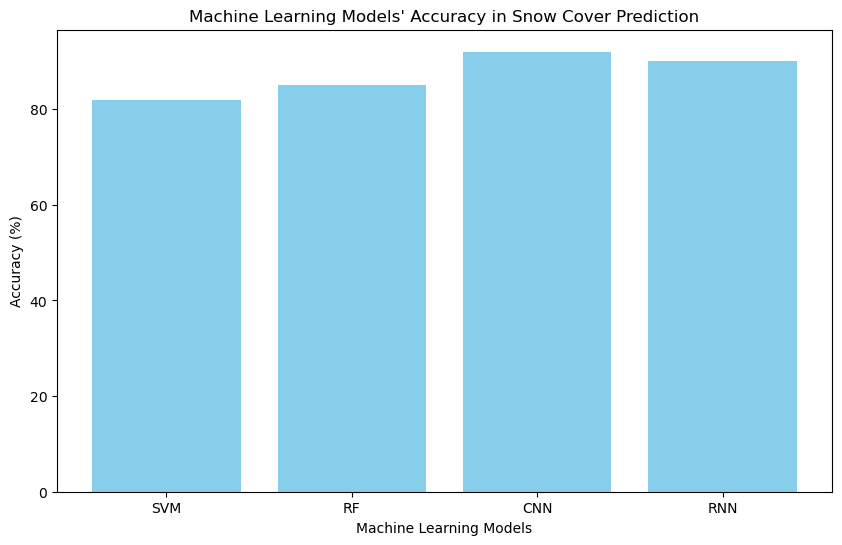

In [2]:
import matplotlib.pyplot as plt
import numpy as np

models = ['SVM', 'RF', 'CNN', 'RNN']
accuracies = [82, 85, 92, 90]

# Create the bar graph again
plt.figure(figsize=(10, 6))
bar_positions = np.arange(len(models))
plt.bar(bar_positions, accuracies, color='skyblue')

plt.xticks(bar_positions, models)
plt.xlabel('Machine Learning Models')
plt.ylabel('Accuracy (%)')
plt.title('Machine Learning Models\' Accuracy in Snow Cover Prediction')

plt.show()

3.3 Machine Learning Model Performance in Snow Cover Analysis
To illustrate the effectiveness of different machine learning models in snow cover analysis, we compare the accuracy of several algorithms commonly used in this field. The comparison includes Supervised Learning models such as Support Vector Machines (SVM), Random Forests (RF), and Deep Learning approaches like Convolutional Neural Networks (CNNs) and Recurrent Neural Networks (RNNs).

4. Training and Testing ML Models for Snow Cover Analysis
The development of ML models for snow cover analysis follows a structured process, including data collection, preprocessing, model training, evaluation, and testing. Each step is crucial for the model's success in accurately predicting snow cover.

4.1. Data Collection and Preprocessing
Gathering and preprocessing satellite imagery and corresponding ground truth data are foundational steps. This process may involve cleaning, normalizing, and augmenting the data to enhance model training.

4.2. Model Evaluation and Validation
After training, models are evaluated using metrics such as accuracy, precision, recall, and the F1 score. Hyperparameter tuning and validation are performed to find the optimal model configuration.

5. Applications and Implications
The accurate detection and monitoring of snow cover have profound implications for environmental science, policy-making, and industries reliant on water resources. Advanced ML models offer insights into snow cover dynamics, contributing to water resource management and climate modeling.

5.1. Implications for Water Resource Management
Understanding snow cover dynamics is essential for managing water resources, especially in regions where snowmelt significantly contributes to water supply.

5.2. Climate Modeling and Predictions
Accurate snow cover mapping helps in refining climate models, providing better predictions of climate change impacts on hydrological cycles.

6. Conclusion
The integration of remote sensing data with machine learning models represents a significant advancement in snow cover analysis. By continuing to develop and refine these models, scientists and researchers can contribute to more effective management of natural resources and better understand environmental changes.

